### ***For Google Colab***

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torchinfo

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Artificial Intelligence/Covid19CT_Experiment

/content/drive/.shortcut-targets-by-id/1wse1sLeq7KeIBIsppZA5bo2MWNOn5NMg/Artificial Intelligence/Covid19CT_Experiment


### ***Main***

In [1]:
import os
from pathlib import Path
import sys

# For Google Colab and Project/test.ipynb
project_path = str(Path().absolute())

if project_path not in sys.path:
    sys.path.append(project_path)

os.listdir(project_path)

['Covid19CT_venv_3.8.10',
 'Database',
 '.DS_Store',
 'DataSplit',
 'FeatureMapSimilarity.py',
 'COVID-CT-master',
 'GradCam.py',
 'Covid19CT.ipynb',
 'test.ipynb',
 'Experimental Results',
 'src']

In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import os
from PIL import Image
import skimage
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

from src.utils.pre_set import SameSeeds
from src.utils.preprocess import CovidCTDataset
from src.utils.train_val import train, test

database_path = project_path + '/Database'
database_split_path = project_path + '/DataSplit'
results_path = project_path + '/Experimental Results'

PROJECT_NAME = 'Test' # 每次實驗要更改
current_result_path = results_path + '/' + PROJECT_NAME + '/'
os.makedirs(current_result_path, exist_ok=True)

# Check Cuda version
print('Torch version:      ', torch.__version__)
print('Torch CUDA version: ', torch.version.cuda)
print('CUDA available? :   ', torch.cuda.is_available())
print('GPU number:         ', torch.cuda.device_count())
# Setting same seeds

seed = 2024
SameSeeds(seed)
print('Set same seed for numpy and torch: ', seed)

Torch version:       2.1.2
Torch CUDA version:  None
CUDA available? :    False
GPU number:          0
Set same seed for numpy and torch:  2024


In [3]:
# Dataset

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # paper
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])


In [4]:
trainset = CovidCTDataset(root_dir = database_path,
                          txt_COVID = database_split_path + '/COVID/trainCT_COVID.txt',
                          txt_NonCOVID = database_split_path + '/NonCOVID/trainCT_NonCOVID.txt',
                          transform = train_transformer)

valset = CovidCTDataset(root_dir = database_path,
                        txt_COVID = database_split_path + '/COVID/valCT_COVID.txt',
                        txt_NonCOVID = database_split_path + '/NonCOVID/valCT_NonCOVID.txt',
                        transform = val_transformer)

testset = CovidCTDataset(root_dir = database_path,
                         txt_COVID = database_split_path + '/COVID/testCT_COVID.txt',
                         txt_NonCOVID = database_split_path + '/NonCOVID/testCT_NonCOVID.txt',
                         transform= val_transformer)


print('Data number of trainset:', trainset.__len__())
print('Data number of valset:  ', valset.__len__())
print('Data number of testset: ', testset.__len__())

Data number of trainset: 425
Data number of valset:   118
Data number of testset:  203


Testset Acc: 137/203 (67.49%)
Testset Loss: 0.0664

              precision    recall  f1-score   support

       COVID     0.6739    0.6327    0.6526        98
   Non-COVID     0.6757    0.7143    0.6944       105

    accuracy                         0.6749       203
   macro avg     0.6748    0.6735    0.6735       203
weighted avg     0.6748    0.6749    0.6743       203


Confusion Matrix: 
 [[62 36]
 [30 75]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

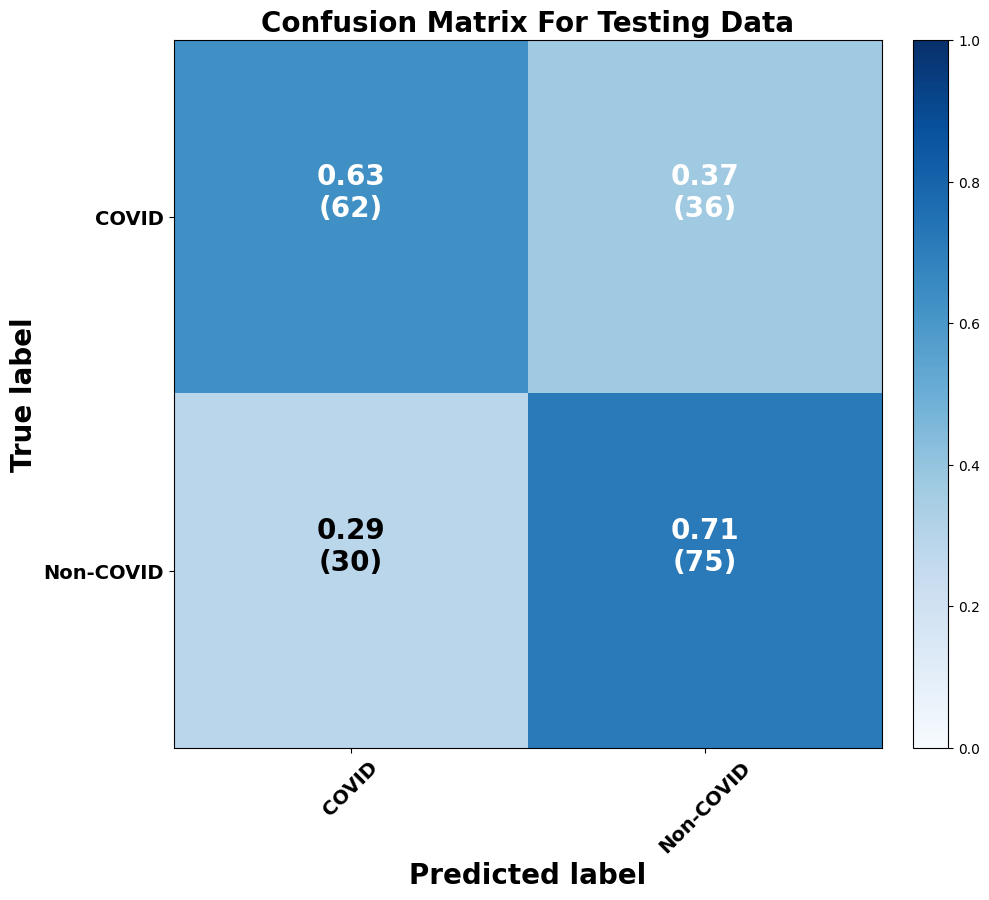

In [5]:
from src.models.ResNet import ResNet50

BATCHSIZE = 16
Param = {'EPOCH': 50,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': 'ReduceLROnPlateau', # CosineAnnealingLR
         'LRScheduler_Tmax': 10, # CosineAnnealingLR
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

train_loader = DataLoader(trainset, batch_size=BATCHSIZE, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=BATCHSIZE, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=BATCHSIZE, drop_last=False, shuffle=False)

train(train_loader, val_loader, ResNet50(), Param, folder_path=current_result_path)

bestmodel_path = current_result_path + f'Best_{ResNet50().name}.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_path, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, folder_path=current_result_path, plot_name=ResNet50().name)